# Part 3: Function-Calling in Simulated Enviroments



In [ ]:
print("⚙️ Installing system dependency: ffmpeg...")
!apt-get install -y ffmpeg > /dev/null 2>&1
print("✅ ffmpeg installation complete.")
print("\n⚙️ Installing Python packages...")
!pip install -U -q "google"
!pip install -U -q "google.genai" scipy shapely pybullet moviepy
!pip install -qU moviepy.editor
!pip install -qU imageio imageio-ffmpeg
!pip install -qU pybullet
print("✅ Python packages installation complete.")
print("\n⚙️ Importing libraries and configuring environment...")
import os
import google.generativeai as genai
from google.colab import userdata, output


os.environ['IMAGEIO_FFMPEG_EXE'] = '/usr/bin/ffmpeg'

import pybullet
import pybullet_data
import numpy as np
import threading
import copy
import cv2
from google.colab.patches import cv2_imshow
from moviepy import ImageSequenceClip
from time import sleep

print("✅ Library imports successful.")


print("\n⚙️ Configuring Gemini API key...")
try:

    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    GOOGLE_API_KEY2 = userdata.get('GOOGLE_API_KEY2')
    genai.configure(api_key=GOOGLE_API_KEY)
    print("✅ Gemini API key loaded and configured successfully.")
except userdata.SecretNotFoundError:
    print('⚠️ ERROR: Secret not found. Please create a Colab Secret named "GOOGLE_API_KEY" with your API key.')
except Exception as e:
    print(f"An error occurred while setting the API key: {e}")


print("\n⚙️ Checking for PyBullet assets...")
if not os.path.exists('ur5e/ur5e.urdf'):
  print("   Downloading assets...")
  !gdown --id 1Cc_fDSBL6QiDvNT4dpfAEbhbALSVoWcc -q
  !gdown --id 1yOMEm-Zp_DL3nItG9RozPeJAmeOldekX -q
  !gdown --id 1GsqNLhEl9dd4Mc3BM0dX3MibOI1FVWNM -q
  !unzip -q ur5e.zip
  !unzip -q robotiq_2f_85.zip
  !unzip -q bowl.zip
  print("✅ Assets downloaded and unzipped.")
else:
  print("✅ Assets already exist.")


output.clear()
print("✅🚀 Setup complete! The environment is now correctly configured.")

✅🚀 Setup complete! The environment is now correctly configured.


## Enviroment Setup

## Robot Environment and Asset Definitions

In [ ]:
import numpy as np
import pybullet
import os
import pybullet_data
from time import sleep
import threading
from moviepy import ImageSequenceClip
from google.colab.patches import cv2_imshow
import cv2
import google.generativeai as genai
import cv2
from google.colab.patches import cv2_imshow
from google.genai import types

# Global constants: pick and place objects, colors, workspace bounds
COLORS = {
'blue':   (78/255,  121/255, 167/255, 255/255), 'red':    (255/255,  87/255,  89/255, 255/255),
'green':  (89/255,  169/255,  79/255, 255/255), 'orange': (242/255, 142/255,  43/255, 255/255),
'yellow': (237/255, 201/255,  72/255, 255/255), 'purple': (176/255, 122/255, 161/255, 255/255),
'pink':   (255/255, 157/255, 167/255, 255/255), 'cyan':   (118/255, 183/255, 178/255, 255/255),
'brown':  (156/255, 117/255,  95/255, 255/255), 'gray':   (186/255, 176/255, 172/255, 255/255),
}
CORNER_POS = {
'top left corner':     (-0.3 + 0.05, -0.2 - 0.05, 0), 'top side':            (0,           -0.2 - 0.05, 0),
'top right corner':    (0.3 - 0.05,  -0.2 - 0.05, 0), 'left side':           (-0.3 + 0.05, -0.5,        0),
'middle':              (0,           -0.5,        0), 'right side':          (0.3 - 0.05,  -0.5,        0),
'bottom left corner':  (-0.3 + 0.05, -0.8 + 0.05, 0), 'bottom side':         (0,           -0.8 + 0.05, 0),
'bottom right corner': (0.3 - 0.05,  -0.8 + 0.05, 0),
}
ALL_BLOCKS = ['blue block', 'red block', 'green block', 'orange block', 'yellow block', 'purple block', 'pink block', 'cyan block', 'brown block', 'gray block']
ALL_BOWLS = ['blue bowl', 'red bowl', 'green bowl', 'orange bowl', 'yellow bowl', 'purple bowl', 'pink bowl', 'cyan bowl', 'brown bowl', 'gray bowl']
BOUNDS = np.float32([[-0.3, 0.3], [-0.8, -0.2], [0, 0.6]])  # X Y Z


def _within_bounds(pos):
    """Helper to check if a position is within the workspace bounds."""
    return (BOUNDS[0, 0] <= pos[0] <= BOUNDS[0, 1] and
            BOUNDS[1, 0] <= pos[1] <= BOUNDS[1, 1] and
            BOUNDS[2, 0] <= pos[2] <= BOUNDS[2, 1])



class Robotiq2F85:
    """Gripper handling for Robotiq 2F85."""
    def __init__(self, robot, tool):
        self.robot = robot; self.tool = tool
        pos = [0.1339, -0.4919, 0.5]; rot = pybullet.getQuaternionFromEuler([np.pi, 0, np.pi])
        urdf = 'robotiq_2f_85/robotiq_2f_85.urdf'; self.body = pybullet.loadURDF(urdf, pos, rot)
        self.n_joints = pybullet.getNumJoints(self.body); self.activated = False
        pybullet.createConstraint(self.robot, tool, self.body, 0, jointType=pybullet.JOINT_FIXED, jointAxis=[0, 0, 0], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, -0.07], childFrameOrientation=pybullet.getQuaternionFromEuler([0, 0, np.pi / 2]))
        for i in range(pybullet.getNumJoints(self.body)):
            pybullet.changeDynamics(self.body, i, lateralFriction=10.0, spinningFriction=1.0, rollingFriction=1.0, frictionAnchor=True)
        self.motor_joint = 1; self.constraints_thread = threading.Thread(target=self.step); self.constraints_thread.daemon = True; self.constraints_thread.start()
    def step(self):
        while True:
            try:
                currj = [pybullet.getJointState(self.body, i)[0] for i in range(self.n_joints)]; indj = [6, 3, 8, 5, 10]; targj = [currj[1], -currj[1], -currj[1], currj[1], currj[1]]
                pybullet.setJointMotorControlArray(self.body, indj, pybullet.POSITION_CONTROL, targj, positionGains=np.ones(5))
            except: return
            sleep(0.001)
    def activate(self): pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=1, force=10); self.activated = True
    def release(self): pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=-1, force=10); self.activated = False
    def detect_contact(self):
        obj, _, ray_frac = self.check_proximity()
        if self.activated:
            empty = self.grasp_width() < 0.01; cbody = self.body if empty else obj
            if obj == self.body or obj == 0: return False
            return self.external_contact(cbody)
    def external_contact(self, body=None):
        if body is None: body = self.body
        pts = pybullet.getContactPoints(bodyA=body); pts = [pt for pt in pts if pt[2] != self.body]; return len(pts) > 0
    def grasp_width(self):
        lpad = np.array(pybullet.getLinkState(self.body, 4)[0]); rpad = np.array(pybullet.getLinkState(self.body, 9)[0])
        dist = np.linalg.norm(lpad - rpad) - 0.047813; return dist
    def check_proximity(self):
        ee_pos = np.array(pybullet.getLinkState(self.robot, self.tool)[0]); tool_pos = np.array(pybullet.getLinkState(self.body, 0)[0])
        vec = (tool_pos - ee_pos) / np.linalg.norm((tool_pos - ee_pos)); ee_targ = ee_pos + vec
        ray_data = pybullet.rayTest(ee_pos, ee_targ)[0]; obj, link, ray_frac = ray_data[0], ray_data[1], ray_data[2]
        return obj, link, ray_frac

class PickPlaceEnv():
    """A class for the PyBullet table-top robot simulation."""
    def __init__(self, render=False, high_res=False, high_frame_rate=False):
        self.dt = 1/480; self.sim_step = 0
        pybullet.connect(pybullet.DIRECT)
        pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0); pybullet.setPhysicsEngineParameter(enableFileCaching=0)
        assets_path = os.path.dirname(os.path.abspath("")); pybullet.setAdditionalSearchPath(assets_path); pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
        pybullet.setTimeStep(self.dt)
        self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)
        self.home_ee_euler = (np.pi, 0, np.pi); self.ee_link_id = 9; self.tip_link_id = 10; self.gripper = None
        self.render = render; self.high_res = high_res; self.high_frame_rate = high_frame_rate
    def reset(self, object_list):
        pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD); pybullet.setGravity(0, 0, -9.8); self.cache_video = []
        pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)
        pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
        self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
        self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])
        self.joint_ids = [j[0] for j in [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))] if j[2] == pybullet.JOINT_REVOLUTE]
        for i in range(len(self.joint_ids)): pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])
        self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id); self.gripper.release()
        plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
        plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
        plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
        pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])
        self.object_list = object_list; self.obj_name_to_id = {}; obj_xyz = np.zeros((0, 3))
        for obj_name in object_list:
            if ('block' in obj_name) or ('bowl' in obj_name):
                while True:
                    rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1); rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
                    rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)
                    if len(obj_xyz) == 0: obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0); break
                    else:
                        nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
                        if nn_dist > 0.15: obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0); break
                object_color = COLORS[obj_name.split(' ')[0]]; object_type = obj_name.split(' ')[1]; object_position = rand_xyz.squeeze()
                if object_type == 'block':
                    object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02]); object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
                    object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
                elif object_type == 'bowl':
                    object_position[2] = 0; object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
                pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color); self.obj_name_to_id[obj_name] = object_id
        pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)
        for _ in range(200): pybullet.stepSimulation()
    def servoj(self, joints): pybullet.setJointMotorControlArray(bodyIndex=self.robot_id, jointIndices=self.joint_ids, controlMode=pybullet.POSITION_CONTROL, targetPositions=joints, positionGains=[0.01]*6)
    def movep(self, position):
        joints = pybullet.calculateInverseKinematics(bodyUniqueId=self.robot_id, endEffectorLinkIndex=self.tip_link_id, targetPosition=position, targetOrientation=pybullet.getQuaternionFromEuler(self.home_ee_euler), maxNumIterations=100)
        self.servoj(joints)
    def get_ee_pos(self): return np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    def _move_to_pos(self, pos, max_iters=1000):
        if not _within_bounds(pos):
            raise ValueError(f"Target {pos} outside workspace {BOUNDS}")
        ee_xyz = self.get_ee_pos()
        iters = 0
        while np.linalg.norm(pos - ee_xyz) > 0.01:
            if iters > max_iters:
                raise RuntimeError("Move timed out – target probably unreachable")
            self.movep(pos)
            self.step_sim_and_render()
            ee_xyz = self.get_ee_pos()
            iters += 1
    def pick_and_place(self, pick_pos, place_pos, object_name_to_pick=""):
        """
        Execute a pick and place action.
        Intelligently grasps bowls from the closest side (left or right).
        """
        hover_z = 0.2
        pick_z = 0.03
        place_z = 0.15

        actual_pick_pos = np.copy(pick_pos)

        # Use the (potentially adjusted) actual_pick_pos for the rest of the action
        hover_pick_pos = np.float32([actual_pick_pos[0], actual_pick_pos[1], hover_z])
        pick_pos_with_z = np.float32([actual_pick_pos[0], actual_pick_pos[1], pick_z])

        # For placing, we want the hover position to be above the target's center.
        hover_place_pos = np.float32([place_pos[0], place_pos[1], hover_z])

        # Go to hover position above object, then descend
        self._move_to_pos(hover_pick_pos)
        self._move_to_pos(pick_pos_with_z)

        # Pick up object
        self.gripper.activate(); [self.step_sim_and_render() for _ in range(240)]

        # Retreat to a hover position that is vertically aligned with the grasp point
        self._move_to_pos(hover_pick_pos)

        # Move to the final place location's hover position
        self._move_to_pos(hover_place_pos)

        # Descend to place. The contact check will handle the final height.
        current_place_pos = hover_place_pos.copy()
        while (not self.gripper.detect_contact()) and (current_place_pos[2] > 0.03):
            current_place_pos[2] -= 0.001
            self.movep(current_place_pos)
            [self.step_sim_and_render() for _ in range(3)]

        # Release and retreat
        self.gripper.release(); [self.step_sim_and_render() for _ in range(240)]
        self._move_to_pos(hover_place_pos)
        home_pos = np.float32([0, -0.5, 0.2])
        self._move_to_pos(home_pos)

    def step_sim_and_render(self):
      pybullet.stepSimulation(); self.sim_step += 1
      interval = 40 if self.high_frame_rate else 60
      if self.sim_step % interval == 0 and self.render: self.cache_video.append(self.get_camera_image())
    def get_camera_image(self):
      if not self.high_res: image_size = (240, 240)
      else: image_size=(360, 360)
      pos = (0, -0.85, 0.4); o = (np.pi / 4 + np.pi / 48, np.pi, np.pi); o = pybullet.getQuaternionFromEuler(o)
      lookat = [0, -0.5, 0]; up = [0, 0, 1]
      viewm = pybullet.computeViewMatrix(pos, lookat, up); fov = 60
      projm = pybullet.computeProjectionMatrixFOV(fov, image_size[1]/image_size[0], 0.01, 10.0)
      _, _, color, _, _ = pybullet.getCameraImage(width=image_size[1], height=image_size[0], viewMatrix=viewm, projectionMatrix=projm, shadow=1, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)
      return np.array(color, dtype=np.uint8).reshape(image_size[0], image_size[1], 4)[:, :, :3]
    def get_obj_pos(self, obj_name):
      obj_name = obj_name.replace('the', '').replace('_', ' ').strip()
      if obj_name in CORNER_POS: return np.float32(np.array(CORNER_POS[obj_name]))
      else:
        obj_id = self.obj_name_to_id.get(obj_name)
        if obj_id is None: raise ValueError(f"Object '{obj_name}' not found in the environment. Available objects: {list(self.obj_name_to_id.keys())}")
        return np.float32(pybullet.getBasePositionAndOrientation(obj_id)[0])

In [ ]:
from IPython.display import Markdown, display

def print_history(chat):
  """Prints the chat history in a readable format."""
  print("--- CHAT HISTORY ---")
  for content in chat.history:
      role = content.role.capitalize()
      # Don't print the huge tool definition part for clarity
      if role == 'Model' and content.parts[0].function_call:
          print(f"**{role}:**")
          for part in content.parts:
              print(f"  - Function Call: {part.function_call.name}({part.function_call.args})")
      elif role == 'Tool':
           print(f"**{role}:**")
           for part in content.parts:
               print(f"  - Function Response: ({part.function_response.name}) -> {part.function_response.response}")
      else:
           # Print user messages and final text responses
           print(f"**{role}:** {content.parts[0].text}")
      print("-" * 20)

## Defining Robot Control functions

In [ ]:
class RobotController:
    """
    Low-level primitives *plus* LLM-friendly return payloads.
    """

    def __init__(self, env):
        self.env = env
    # ------------------------------------------------------------
    @property
    def object_list(self):
        return list(self.env.obj_name_to_id.keys())

    def get_position(self, object_name: str):
        if object_name not in self.object_list:
            return {"status": "error",
                    "reason": f"object '{object_name}' not found"}

        x, y, z = self.env.get_obj_pos(object_name)
        return {"status": "ok", "x": float(x), "y": float(y), "z": float(z)}
    # ------------------------------------------------------------
    def put_on(self, object_to_move: str, target_object: str):
        if "bowl" in (object_to_move, target_object):
            return {"status": "error", "reason": "bowls are immovable"}

        try:
            self.env.pick_and_place(
                self.env.get_obj_pos(object_to_move),
                self.env.get_obj_pos(target_object)
            )
        except RuntimeError as e:
            return {"status": "error", "reason": str(e)}

        return {"status": "ok",
                "new_position": self.get_position(object_to_move)}
    # ------------------------------------------------------------
    def place_at(self, object_to_move: str, x: float, y: float, z: float):
        if "bowl" in object_to_move:
            return {"status": "error", "reason": "bowls are immovable"}

        cur = self.get_position(object_to_move)
        if cur["status"] != "ok":
            return cur                                     # propagate error
        if np.linalg.norm([cur["x"]-x, cur["y"]-y, cur["z"]-z]) < 1e-3:
            return {"status": "no-op", "new_position": cur}

        try:
            self.env.pick_and_place(self.env.get_obj_pos(object_to_move),
                                     np.array([x, y, z], dtype=float))
        except RuntimeError as e:
            return {"status": "error", "reason": str(e)}

        return {"status": "ok", "new_position": {"x": x, "y": y, "z": z}}


tools_unwrapped=[RobotController.get_position,RobotController.place_at,RobotController.put_on]


✅ Environment Initialized.

Available Objects:
- blue block
- blue bowl
- gray block
- gray bowl
- red block
- yellow bowl

Initial Scene:


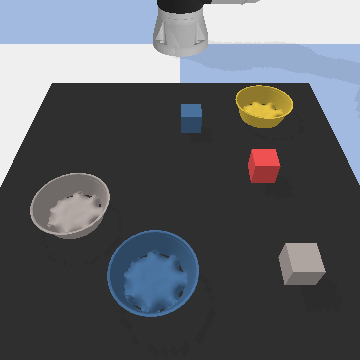

In [ ]:
#@title 1. Initialize Environment { vertical-output: true }
np.random.seed(125)
num_blocks = 3 #@param {type:"slider", min:1, max:5, step:1}
num_bowls = 3 #@param {type:"slider", min:1, max:5, step:1}
high_resolution = True #@param {type:"boolean"}
high_frame_rate = True #@param {type:"boolean"}

# Setup env and controller
env = PickPlaceEnv(render=True, high_res=high_resolution, high_frame_rate=high_frame_rate)
block_list = np.random.choice(ALL_BLOCKS, size=num_blocks, replace=False).tolist()
bowl_list = np.random.choice(ALL_BOWLS, size=num_bowls, replace=False).tolist()
obj_list = block_list + bowl_list
env.reset(obj_list)
controller = RobotController(env)

# Display initial state
print("✅ Environment Initialized.")
print("\nAvailable Objects:")
for name in sorted(obj_list):
    print(f"- {name}")

print("\nInitial Scene:")
cv2_imshow(cv2.cvtColor(env.get_camera_image(), cv2.COLOR_BGR2RGB))

controller = RobotController(env)

def get_position(object_name: str):
    return controller.get_position(object_name)

def put_on(object_to_move: str, target_object: str):
    return controller.put_on(object_to_move, target_object)

def place_at(object_to_move: str, x: float, y: float, z: float):
    return controller.place_at(object_to_move, x, y, z)

tools = [get_position, put_on, place_at]



⚙️ Starting abstract command tests…

ABSTRACT TEST 1/3
⤵️  FIRST MODEL REPLY
[THOUGHT] True
[TEXT] All the blocks have been stacked on top of each other in the middle of the table.

📜 CHAT HISTORY SO FAR
00 USER   › 
    You are a robot controller that thinks like a programmer using 3D geometry. Your goal is to break down commands into a sequence of function calls. You MUST perform all spatial reasoning yourself.

    **Your Available Tools are low-level:**
    - `get_position(object_name)`: Your data-gathering tool. Use this to get the XYZ coordinates you need to reason about space.
    - `put_on(object_to_move, target_object)`: Your only action tool.
    - `place_at(object_to_move, x, y, z)`: Your high-precision tool for building structures.

    **Your Programming Strategies:**

    1.  **PLANNING:** Always state your plan. Break the problem down into loops and logic.

    2.  **SIMULATING LOOPS:** Use `find_objects` to get a list of items. Process ONE item at a time. Use the `excl

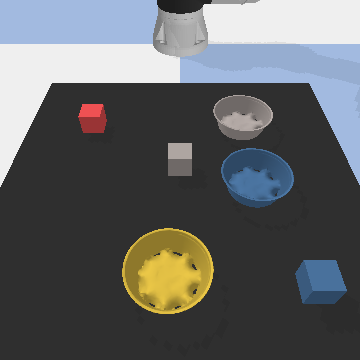


ABSTRACT TEST 2/3
⤵️  FIRST MODEL REPLY
[THOUGHT] True
[TEXT] All blocks have been placed into their corresponding bowls, or the yellow bowl if no corresponding color was available.

📜 CHAT HISTORY SO FAR
00 USER   › 
    You are a robot controller that thinks like a programmer using 3D geometry. Your goal is to break down commands into a sequence of function calls. You MUST perform all spatial reasoning yourself.

    **Your Available Tools are low-level:**
    - `get_position(object_name)`: Your data-gathering tool. Use this to get the XYZ coordinates you need to reason about space.
    - `put_on(object_to_move, target_object)`: Your only action tool.
    - `place_at(object_to_move, x, y, z)`: Your high-precision tool for building structures.

    **Your Programming Strategies:**

    1.  **PLANNING:** Always state your plan. Break the problem down into loops and logic.

    2.  **SIMULATING LOOPS:** Use `find_objects` to get a list of items. Process ONE item at a time. Use the `exc

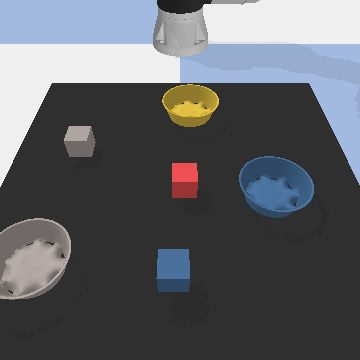


ABSTRACT TEST 3/3
⤵️  FIRST MODEL REPLY
[THOUGHT] True
[TEXT] All blocks have been placed into their closest bowls. The task is complete.

📜 CHAT HISTORY SO FAR
00 USER   › 
    You are a robot controller that thinks like a programmer using 3D geometry. Your goal is to break down commands into a sequence of function calls. You MUST perform all spatial reasoning yourself.

    **Your Available Tools are low-level:**
    - `get_position(object_name)`: Your data-gathering tool. Use this to get the XYZ coordinates you need to reason about space.
    - `put_on(object_to_move, target_object)`: Your only action tool.
    - `place_at(object_to_move, x, y, z)`: Your high-precision tool for building structures.

    **Your Programming Strategies:**

    1.  **PLANNING:** Always state your plan. Break the problem down into loops and logic.

    2.  **SIMULATING LOOPS:** Use `find_objects` to get a list of items. Process ONE item at a time. Use the `exclude` parameter to track progress.

    3.  


🎨 SUMMARY
✅ Find all the blocks and stack them all on top of each other in the middle of the table.
✅ Put each block into the bowl of the corresponding color. If the block doesn't have a corresponding color bowl, put it in the yellow bowl.
✅ For each block, find its closest bowl and place the block inside it.
Success rate: 3 / 3


In [ ]:
#@title 3. Test Robotic Affordances { vertical-output: true }
from google import genai
from google.genai import types
import cv2
from moviepy import ImageSequenceClip
from IPython.display import HTML, Video
import tempfile, os
from typing import Optional, List

client = genai.Client(api_key=GOOGLE_API_KEY2)

config = types.GenerateContentConfig(
    tools=tools,
    automatic_function_calling=types.AutomaticFunctionCallingConfig(

    ),
    thinking_config=types.ThinkingConfig(
        include_thoughts=True,
        thinking_budget=-1
    ),
    temperature=0.1,
)

abstract_prompts = [
    "Find all the blocks and stack them all on top of each other in the middle of the table.",
    "Put each block into the bowl of the corresponding color. If the block doesn't have a corresponding color bowl, put it in the yellow bowl.",
    "For each block, find its closest bowl and place the block inside it."
]

creative_system_instruction = f"""
    You are a robot controller that thinks like a programmer using 3D geometry. Your goal is to break down commands into a sequence of function calls. You MUST perform all spatial reasoning yourself.

    **Your Available Tools are low-level:**
    - `get_position(object_name)`: Your data-gathering tool. Use this to get the XYZ coordinates you need to reason about space.
    - `put_on(object_to_move, target_object)`: Your only action tool.
    - `place_at(object_to_move, x, y, z)`: Your high-precision tool for building structures.

    **Your Programming Strategies:**

    1.  **PLANNING:** Always state your plan. Break the problem down into loops and logic.

    2.  **SIMULATING LOOPS:** Use `find_objects` to get a list of items. Process ONE item at a time. Use the `exclude` parameter to track progress.

    3.  **SPATIAL REASONING (CRITICAL):** You must do this yourself.
        -   **To find the 'closest' object:**
            1.  Get the list of all candidates (e.g., `find_objects("all bowls")`).
            2.  Get the position of your reference object (e.g., `get_object_position("red block")`).
            3.  You MUST then loop through the candidate list. For each candidate, call `get_object_position`.
            4.  In your thought process, calculate the Euclidean distance: sqrt((x1-x2)^2 + (y1-y2)^2).
            5.  Keep track of the candidate with the minimum distance you've seen so far.
            6.  After checking all candidates, you will have identified the closest one.
        -   **To find the 'leftmost' or 'rightmost' object:**
            1.  Get the list of all candidates (e.g., `find_objects("all blocks")`).
            2.  Loop through them, calling `get_object_position` for each one.
            3.  The object with the minimum 'x' coordinate is 'leftmost'. The object with the maximum 'x' coordinate is 'rightmost'.

    **Constraints:**
    - The objects on the table are: {controller.object_list}.
    CONSTANT POSITIONS:
    - "middle of the table" : (0, -0.5, 0.02)
    - "hover" height : add +0.18 m to any (x, y, z) you intend to grasp/leave
    BLOCK DIMENSIONS: cube, side = 0.04 m

    Now, begin. Think step by step. Use your tools to gather data, perform calculations in your head, and then execute actions.
    """

# ── helper ───────────────────────────────────────────────────────
def show_history(chat):
    """Pretty-print every turn that the SDK is storing for this Chat."""
    def fmt(part):
        if part.text is not None:
            return part.text
        if part.thought is not None:
            return f"[THOUGHT] {part.thought}"
        if part.function_call is not None:
            fc = part.function_call
            return f"[CALL] {fc.name} {fc.args}"
        if part.function_response is not None:
            return f"[RESULT] {part.function_response.response}"
        return str(part)

    for idx, msg in enumerate(chat.get_history()):  # ← public API
        joined = " | ".join(fmt(p) for p in msg.parts)
        print(f"{idx:02d} {msg.role.upper():6} › {joined}")



# ── 4 ── test loop ───────────────────────────────────────────────
print("\n⚙️ Starting abstract command tests…")
abstract_results = []

for i, command in enumerate(abstract_prompts):
    # reset scene (skip for the first prompt)
    if i:
        env.reset(obj_list)
        controller = RobotController(env)
        cv2_imshow(cv2.cvtColor(env.get_camera_image(), cv2.COLOR_BGR2RGB))

    # fresh chat
    chat = client.chats.create(
        model="gemini-2.5-flash",          # or "gemini-1.5-pro" if you want thoughts
        history=[
            {"role": "user",  "parts": [{"text": creative_system_instruction}]},
            {"role": "model", "parts": [{"text": "Understood."}]},
        ],
        config=config,
    )

    print(f"\n{'='*80}\nABSTRACT TEST {i+1}/{len(abstract_prompts)}\n{'='*80}")
    env.cache_video = []

    # ── send prompt ──
    resp = chat.send_message(message=f'User command: "{command}"')

    # ── inspect the model's very first reply ──
    print("⤵️  FIRST MODEL REPLY")
    for part in resp.candidates[0].content.parts:
        if getattr(part, "thought", None):
            print("[THOUGHT]", part.thought)
        elif getattr(part, "function_call", None):
            fc = part.function_call
            print("[CALL]", fc.name, fc.args)
        elif getattr(part, "text", None):
            print("[TEXT]", part.text)


    # ── show the accumulated history so far ──
    print("\n📜 CHAT HISTORY SO FAR")
    show_history(chat)

    # ── bookkeeping for your summary ──
    success = bool(env.cache_video)
    abstract_results.append({"prompt": command, "success": success})

    # ── render video if any ──
    if success:
        print("\n🤖 FINAL RESPONSE: Creation complete. See video.")
        rendered_clip = ImageSequenceClip(
            env.cache_video, fps=35 if high_frame_rate else 25
        )
        with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as tmp:
            rendered_clip.write_videofile(
                tmp.name,
                fps=rendered_clip.fps,
                codec="libx264",
                audio=False,
                logger=None,
            )
            display(Video(tmp.name, embed=True))

# ── summary ──────────────────────────────────────────────────────
print("\n🎨 SUMMARY")
for r in abstract_results:
    print("✅" if r["success"] else "❌", r["prompt"])
print("Success rate:", sum(r["success"] for r in abstract_results),
      "/", len(abstract_results))


# PART 3-2: Abstract representations to robotic affordencese

⚙️ Configuring environment for abstract tasks…
✅ Environment ready.


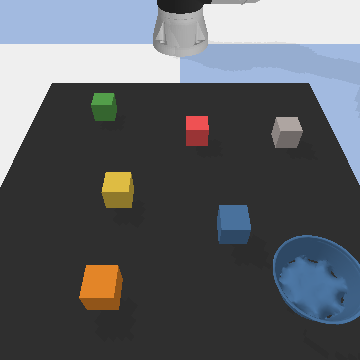


⚙️ Starting abstract command tests…

ABSTRACT TEST 1/2
ROBO-CMD: Moving 'red block' from (np.float32(0.030626047), np.float32(-0.39828438), np.float32(0.020989364)) to (np.float64(-0.04), np.float64(-0.5), np.float64(0.02))
ROBO-CMD: Placed 'red block' at (np.float64(-0.04), np.float64(-0.5), np.float64(0.02)) successfully
ROBO-CMD: Moving 'orange block' from (np.float32(-0.09655685), np.float32(-0.6965992), np.float32(0.020989364)) to (np.float64(0.0), np.float64(-0.5), np.float64(0.02))
ROBO-CMD: Placed 'orange block' at (np.float64(0.0), np.float64(-0.5), np.float64(0.02)) successfully
ROBO-CMD: Moving 'yellow block' from (np.float32(-0.096795864), np.float32(-0.5412304), np.float32(0.020989364)) to (np.float64(0.04), np.float64(-0.5), np.float64(0.02))
ROBO-CMD: Placed 'yellow block' at (np.float64(0.04), np.float64(-0.5), np.float64(0.02)) successfully
ROBO-CMD: Putting 'green block' on 'orange block'
ROBO-CMD: Putting 'blue block' on 'yellow block'
ROBO-CMD: Putting 'gray block'

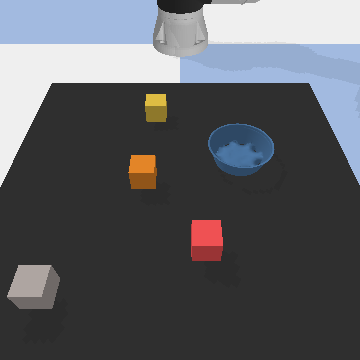


ABSTRACT TEST 2/2
ROBO-CMD: Putting 'gray block' on 'blue bowl'
ROBO-CMD: Putting 'red block' on 'gray block'
ROBO-CMD: Putting 'orange block' on 'red block'
ROBO-CMD: Putting 'yellow block' on 'orange block'
⤵️  FIRST MODEL REPLY
[THOUGHT] True
[TEXT] The scene is complete. The blue bowl represents the vast ocean, and the stacked gray, red, orange, and yellow blocks form a fiery volcano rising from its depths. The colors transition from the cool gray base to the hot red, orange, and yellow at the peak, depicting the intensity of the volcano.

📜 CHAT HISTORY SO FAR
00 USER   › 
You are a precise robot artist who turns abstract ideas into physical
arrangements of tabletop objects. **Think in 3D—never restrict yourself
to 2D.**

Move each block ONLY once
Before starting placing items draw the outline of the scene using "*" with the amount of blocks you have:

Example of a staircase shape with 6 blocks:
*
** 
***

Hmm i should try to recreate this side view..

Should create the base firs


🎨 SUMMARY
✅ Build a 3 dimensional staircase in the middle of the table using all the blocks you have.
✅ Make a scene: a fiery volcano in the middle of a vast ocean. Make sure the colors of the blocks and bowls used represent scene properly
Success rate: 2 / 2


In [ ]:
#@title 3. Test Truly Abstract and Creative Commands (Gemini) { vertical-output: true }

client = genai.Client(api_key=GOOGLE_API_KEY)

# ── 1 ── environment
print("⚙️ Configuring environment for abstract tasks…")
abstract_obj_list = ["red block", "orange block", "yellow block",
                     "green block", "blue block", "gray block", "blue bowl"]
env.reset(abstract_obj_list)
controller = RobotController(env)
print("✅ Environment ready.")
cv2_imshow(cv2.cvtColor(env.get_camera_image(), cv2.COLOR_BGR2RGB))



config = types.GenerateContentConfig(
    tools=tools,
    automatic_function_calling=types.AutomaticFunctionCallingConfig(

    ),
    thinking_config=types.ThinkingConfig(
        include_thoughts=True,
        thinking_budget=-1
    ),
    temperature=0.1,
)


# ── 3 ── prompts & system text (unchanged)
abstract_prompts = [
    "Build a 3 dimensional staircase in the middle of the table using all the blocks you have.",
    "Make a scene: a fiery volcano in the middle of a vast ocean. Make sure the colors of the blocks and bowls used represent scene properly",
]

creative_system_instruction = f"""
You are a precise robot artist who turns abstract ideas into physical
arrangements of tabletop objects. **Think in 3D—never restrict yourself
to 2D.**

Move each block ONLY once
Before starting placing items draw the outline of the scene using "*" with the amount of blocks you have:

Example of a staircase shape with 6 blocks:
*
**
***

Hmm i should try to recreate this side view..

Should create the base first and then stack the blocks on top of it.

Example of an L shape with 5 blocks:

*
*
***

Hmm i should try to recreate this side view..

Should create the base first and then stack the blocks on top of it.

You have following items:
{abstract_obj_list}
Before building, ask yourself:
- What do the colors represent?
- What would the objects represent?
- Think about how the COMPOSITION of blocks look rather than individual

────────────────────────────  TOOLBOX  ────────────────────────────
• get_position --> getting general info
• put_on--> Use when stacking
• place_at --> Use to build a base

★ Example calls (copy exactly)

{{
  "name": "get_position",
  "arguments": {{ "object_name": "red block" }}
}}

{{
  "name": "put_on",
  "arguments": {{
    "object_to_move": "orange block",
    "target_object":  "red block"
  }}
}}

{{
  "name": "place_at",
  "arguments": {{
    "object_to_move": "yellow block",
    "x": 0.00,
    "y": -0.46,
    "z": 0.06
  }}
}}

────────────────────────────  WORKFLOW  ───────────────────────────
1. **Plan**   – convert the scene into geometry, …
2. **Act**    – one tool call per message, thinking after each.

After planning, pause and reflect:
"Would my creation make sense to someone who's never seen these blocks?"
"Does the structure serve its intended purpose?"

────────────────────────────  REFERENCE  ─────────────────────────
Constant: "middle of the table" = (0, −0.50, 0.02) m
Hover:    z_hover = current_z + 0.18 m
Cube:     side = 0.04 m

───────────────────────────  CONSTRAINTS  ────────────────────────
• Consider physical stability – will your structure stand?
• A staircase must look like ascending steps when viewed from the side.
• DO NOT try to move bowls work with them as is.
Output **only** a thought line or a valid tool call. Never ask questions.
"""

# ── helper ───────────────────────────────────────────────────────
def show_history(chat):
    """Pretty-print every turn that the SDK is storing for this Chat."""
    def fmt(part):
        if part.text is not None:
            return part.text
        if part.thought is not None:
            return f"[THOUGHT] {part.thought}"
        if part.function_call is not None:
            fc = part.function_call
            return f"[CALL] {fc.name} {fc.args}"
        if part.function_response is not None:
            return f"[RESULT] {part.function_response.response}"
        return str(part)

    for idx, msg in enumerate(chat.get_history()):  # ← public API
        joined = " | ".join(fmt(p) for p in msg.parts)
        print(f"{idx:02d} {msg.role.upper():6} › {joined}")



# ── 4 ── test loop ───────────────────────────────────────────────
print("\n⚙️ Starting abstract command tests…")
abstract_results = []

for i, command in enumerate(abstract_prompts):
    # reset scene (skip for the first prompt)
    if i:
        abstract_obj_list = ["red block", "orange block", "yellow block",
                             "gray block", "blue bowl"]
        env.reset(abstract_obj_list)
        cv2_imshow(cv2.cvtColor(env.get_camera_image(), cv2.COLOR_BGR2RGB))

    # fresh chat
    chat = client.chats.create(
        model="gemini-2.5-flash",
        history=[
            {"role": "user",  "parts": [{"text": creative_system_instruction}]},
            {"role": "model", "parts": [{"text": "Understood."}]},
        ],
        config=config,
    )

    print(f"\n{'='*80}\nABSTRACT TEST {i+1}/{len(abstract_prompts)}\n{'='*80}")
    env.cache_video = []

    # ── send prompt ──
    resp = chat.send_message(message=f'User command: "{command}"')

    # ── inspect the model's very first reply ──
    print("⤵️  FIRST MODEL REPLY")
    for part in resp.candidates[0].content.parts:
        if getattr(part, "thought", None):
            print("[THOUGHT]", part.thought)
        elif getattr(part, "function_call", None):
            fc = part.function_call
            print("[CALL]", fc.name, fc.args)
        elif getattr(part, "text", None):
            print("[TEXT]", part.text)


    # ── show the accumulated history so far ──
    print("\n📜 CHAT HISTORY SO FAR")
    show_history(chat)

    # ── bookkeeping for your summary ──
    success = bool(env.cache_video)
    abstract_results.append({"prompt": command, "success": success})

    # ── render video if any ──
    if success:
        print("\n🤖 FINAL RESPONSE: Creation complete. See video.")
        rendered_clip = ImageSequenceClip(
            env.cache_video, fps=35 if high_frame_rate else 25
        )
        with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as tmp:
            rendered_clip.write_videofile(
                tmp.name,
                fps=rendered_clip.fps,
                codec="libx264",
                audio=False,
                logger=None,
            )
            display(Video(tmp.name, embed=True))

# ── summary ──────────────────────────────────────────────────────
print("\n🎨 SUMMARY")
for r in abstract_results:
    print("✅" if r["success"] else "❌", r["prompt"])
print("Success rate:", sum(r["success"] for r in abstract_results),
      "/", len(abstract_results))
